# Проект GeekBrains: Предсказание стоимости квартир в Москве

In [1]:
import numpy as np
import pandas as pd 
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'


Функция для уменьшения памяти датасета

In [6]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
train_df = reduce_mem_usage(pd.read_csv(TRAIN_DATASET_PATH, sep=','))
train_df.tail()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250
9999,7202,94,1.0,35.815475,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.625000


### Описание датасета:

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Типы данных в датасете:

* целочисленные int32, int16, int8
* вещественные float32
* категориальные category

Количество категориальных признаков - 3.

In [9]:
test_df = reduce_mem_usage(pd.read_csv(TEST_DATASET_PATH, sep=','))
test_df.tail()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698120,94.521461,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003260,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

Количество строк в train_df: 10000

Количество строк в test_df: 5000

Количество признаков в train_df: 20

Количество признаков в test_df: 19

Последний признак "Price" необходимо рассчиать с помощью моделей

In [11]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### EDA

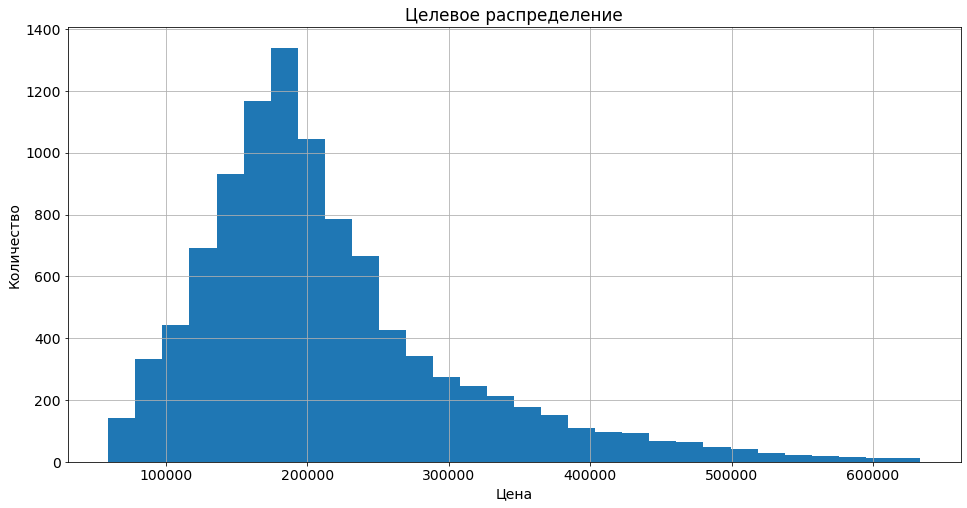

In [13]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Количество')
plt.xlabel('Цена')

plt.title('Целевое распределение')
plt.show()

Судя по графику неадеквтаных выбросов не наблюдается (большее количество квартир в средней ценовой категории)

In [14]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [15]:
df_num_features = train_df.select_dtypes(include=['float32', 'float16','int8', 'int32','int16'])
df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.875000
1,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.546875
2,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.718750
3,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.000000
4,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,52,10311,6,NaN,1,9,119367.453125
9996,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,2,629,1,NaN,0,0,199715.156250
9997,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,NaN,1,5,165953.906250
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,3,125.0,3,5,171842.406250


In [16]:
df_num_features.drop(['Price'], axis=1, inplace=True)

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

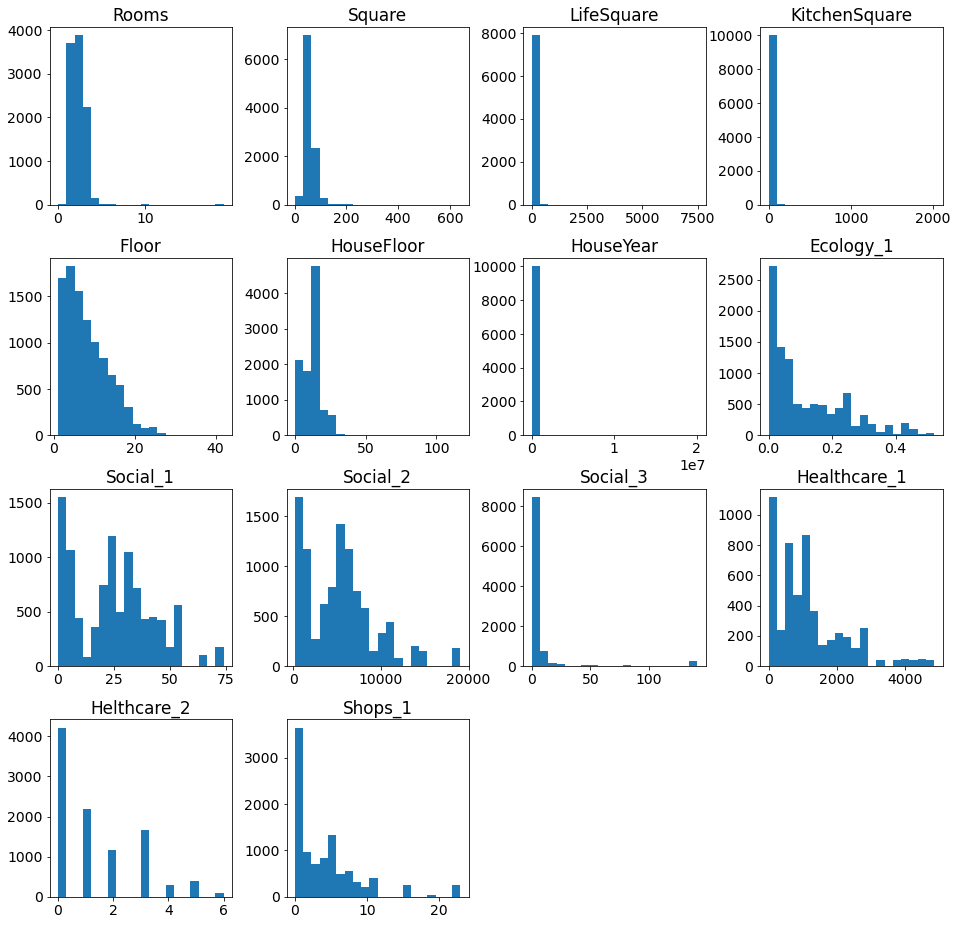

In [17]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False)

Rooms, LifeSquare, KithcenSquare, Floor, HouseFloor: слишком большое макс. знач.

In [18]:
obj_cat = train_df.select_dtypes(include="category").columns.tolist()\
+ train_df.select_dtypes(include="object").columns.tolist()

In [19]:
for el in obj_cat:
    print(train_df.value_counts(el))

Ecology_2
B    9903
A      97
dtype: int64
Ecology_3
B    9725
A     275
dtype: int64
Shops_2
B    9175
A     825
dtype: int64
Id
0        1
4927     1
4916     1
4918     1
4920     1
        ..
15035    1
15036    1
15037    1
15038    1
9999     1
Length: 10000, dtype: int64
DistrictId
27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
209      1
174      1
199      1
Length: 205, dtype: int64


### Отработка выбросов

#### Rooms

In [20]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [21]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,0


In [22]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = 5

In [23]:
train_df['Rooms'].value_counts()

2.0    3880
1.0    3713
3.0    2235
4.0     150
5.0      22
Name: Rooms, dtype: int64

#### Square, LifeSquare

In [24]:
train_df['Square'].value_counts()

81.867165    2
37.498161    2
44.482914    2
80.794792    2
65.285133    2
            ..
46.324123    1
43.100792    1
82.824371    1
38.042900    1
43.554482    1
Name: Square, Length: 9995, dtype: int64

In [25]:
train_df['LifeSquare'].value_counts()

33.859653    2
19.622097    1
52.977779    1
29.914387    1
33.679745    1
            ..
23.157387    1
25.492685    1
21.827230    1
31.601423    1
31.151680    1
Name: LifeSquare, Length: 7886, dtype: int64

In [26]:
(train_df['Square'] < train_df['LifeSquare']).value_counts()

False    9518
True      482
dtype: int64

In [30]:
train_df['Square'], train_df['LifeSquare'] = np.where(train_df['Square'] \
                                                      < train_df['LifeSquare'],(train_df['LifeSquare'] \
                                                                                ,train_df['Square']), (train_df['Square'],train_df['LifeSquare']))

In [31]:
(train_df['Square'] < train_df['LifeSquare']).value_counts()

False    10000
dtype: int64

#### KitchenSquare

In [32]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [33]:
(13.0, 0.0)
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [34]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

#### Floor, HouseFloor

In [35]:
train_df['Floor'].unique()

array([ 4,  7,  2, 10, 16,  9,  1,  8, 12,  3,  5,  6, 11, 18, 13, 21, 22,
       15, 17, 14, 23, 19, 20, 26, 25, 27, 31, 24, 28, 32, 33, 42, 37],
      dtype=int8)

In [36]:
train_df['HouseFloor'].unique()

array([ 10.,   8.,  17.,  22.,  16.,   9.,  12.,  20.,  14.,  24.,   5.,
         0.,   1.,   3.,   4.,   6.,   7.,  25.,  21.,  11.,   2.,  23.,
        19.,  15.,  18.,  32.,  45.,  30.,  99.,  40.,  44.,  13.,  39.,
        28.,  27.,  37., 117.,  31.,  48.,  47.,  29.,  36.,  38.,  26.],
      dtype=float32)

Есть сомнительные значения

In [37]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

Большое количество домов превышают значение этажности HouseFloor

Сделаем новый признак:

In [38]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

Этаж равный нулю приравняем к медиане

In [39]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [40]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

Несоответствия заменим на рандомное число от 1 до максимального этажа конкретного дома:

In [41]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [42]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

#### HouseYear

In [43]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [44]:
current_year = datetime.now().year
train_df['HouseYear_outlier'] = 0
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1

In [45]:
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear'] = current_year

### Отработка пропусков

In [46]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
HouseYear_outlier        0
dtype: int64

#### LifeSquare

In [47]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head()

,Square,LifeSquare,KitchenSquare
0,115.027313,NaN,10.0
1,39.832523,23.169222,8.0
2,78.342216,47.671970,10.0
3,40.409908,NaN,3.0
4,64.285065,38.562515,9.0


Жилую площадь следует вывести из разности общей площади и кухонной площади, учитывая остальные маленькие площади (балкон, коридор и тд). Пусть остальная площадь будет равняться 3 кв.м.(Возьмем ее из стандартного образца)

In [49]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [50]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
HouseYear_outlier        0
LifeSquare_nan           0
dtype: int64

#### Healthcare_1

In [51]:
train_df['Healthcare_1_nan'] = train_df['Healthcare_1'].isna() * 1
condition = (train_df['Healthcare_1'].isna())     
train_df.loc[condition, 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [52]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = 5
        
        #Square
        
        X['Square'], X['LifeSquare'] = np.where(X['Square'] < X['LifeSquare'],(X['LifeSquare'],X['Square']),\
                                                (X['Square'],X['LifeSquare']))

        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = 1
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] -\
        X.loc[condition, 'KitchenSquare'] - 3
        
        # Healthcare_1
        
        X['Healthcare_1_nan'] = X['Healthcare_1'].isna() * 1
        condition = (train_df['Healthcare_1'].isna())     
        X.loc[condition, 'Healthcare_1'] = X['Healthcare_1'].median()
            
        
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков

In [53]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [54]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head(10)

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
5,62,247
6,30,228
7,58,179
8,53,174
9,21,165


In [55]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.875000,0,0,0,1,1,851
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.546875,0,0,0,0,0,78
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.718750,0,0,0,0,0,652
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,0,1,1,168106.000000,0,0,0,1,1,652
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.093750,0,0,0,0,1,89


In [56]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [57]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [58]:
train_df['DistrictId'].value_counts().sort_index()

0       48
1      652
10      56
100     25
101     97
      ... 
95      15
96      71
97      10
98      21
99      97
Name: DistrictId, Length: 205, dtype: int64

#### MedPriceByDistrict

In [59]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202706.093750


In [61]:
med_price_by_district.shape

(671, 3)

In [62]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,1,305018.875000,0,0,0,1,1,851,1,213530.781250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,177734.546875,0,0,0,0,0,78,0,146032.828125
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,1,282078.718750,0,0,0,0,0,652,1,244005.281250
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,1,168106.000000,0,0,0,1,1,652,1,146735.671875
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,1,343995.093750,0,0,0,0,1,89,0,201584.437500


#### MedPriceByFloorYear

In [64]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1955), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1955) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1955, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [65]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [66]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [67]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,0,0,1,1,851,1,213530.781250,6,2
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,78,0,146032.828125,3,3
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,652,1,244005.281250,4,1
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,0,0,0,1,1,652,1,146735.671875,3,4
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,0,0,0,1,89,0,201584.437500,3,5


In [68]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,379841.43750
1,1,2,321488.56250
2,1,3,425423.56250
3,1,4,274992.46875
4,2,1,296102.78125


In [69]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,0,1,1,851,1,213530.781250,6,2,163047.09375
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,0,0,78,0,146032.828125,3,3,190950.12500
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,0,0,652,1,244005.281250,4,1,201995.03125
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,0,0,1,1,652,1,146735.671875,3,4,183882.81250
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,0,0,1,89,0,201584.437500,3,5,173028.96875


In [71]:
def age_to_binary_cat(X):
    X['age_to_binary_cat'] = 0
    X.loc[X['HouseYear'] >= 2011, 'age_to_binary_cat'] = 1  

    return X

In [72]:
train_df = age_to_binary_cat(train_df)
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,age_to_binary_cat
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,1,1,851,1,213530.781250,6,2,163047.09375,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,0,78,0,146032.828125,3,3,190950.12500,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,0,652,1,244005.281250,4,1,201995.03125,0


#### MedHealthByDistrict

In [74]:
med_health_by_district = train_df.groupby(['DistrictId'], \
                                          as_index=False).agg({'Helthcare_2':'median'}).rename(columns= \
                                                                                               {'Helthcare_2': 'MedHealthByDistrict'})
med_health_by_district

,DistrictId,MedHealthByDistrict
0,0,5.0
1,1,0.0
2,10,0.0
3,100,2.0
4,101,3.0
...,...,...
200,95,1.0
201,96,1.0
202,97,5.0
203,98,3.0


In [75]:
train_df = train_df.merge(med_health_by_district, on='DistrictId', how='left')
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,age_to_binary_cat,MedHealthByDistrict
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,1,1,851,1,213530.781250,6,2,163047.09375,1,0.0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,78,0,146032.828125,3,3,190950.12500,0,1.0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,652,1,244005.281250,4,1,201995.03125,0,0.0


#### MedSocialByDistrict

In [76]:
med_social_by_district_3 = train_df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedSocialByDistrict3'})

med_social_by_district_3.head(10)

,DistrictId,MedSocialByDistrict3
0,0,165963.062500
1,1,183663.437500
2,10,217749.656250
3,100,234032.843750
4,101,184276.500000
5,102,172906.875000
6,103,253670.906250
7,104,366925.281250
8,105,197225.703125
9,106,267311.500000


In [77]:
train_df = train_df.merge(med_social_by_district_3, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,age_to_binary_cat,MedHealthByDistrict,MedSocialByDistrict3
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,1,851,1,213530.781250,6,2,163047.09375,1,0.0,146171.43750
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,78,0,146032.828125,3,3,190950.12500,0,1.0,183678.12500
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,652,1,244005.281250,4,1,201995.03125,0,0.0,183663.43750
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,1,652,1,146735.671875,3,4,183882.81250,0,0.0,183663.43750
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,1,89,0,201584.437500,3,5,173028.96875,0,0.0,181706.71875


In [78]:
med_social_by_district_2 = train_df.groupby(['DistrictId'],\
                                       as_index=False).agg({'Social_2':'median'})\
.rename(columns={'Social_2': 'MedSocialByDistrict2'})
med_social_by_district_2

,DistrictId,MedSocialByDistrict2
0,0,4756.0
1,1,264.0
2,10,7976.0
3,100,3975.0
4,101,6558.0
...,...,...
200,95,3369.0
201,96,14892.0
202,97,5148.0
203,98,5212.0


In [79]:
train_df = train_df.merge(med_social_by_district_2, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,age_to_binary_cat,MedHealthByDistrict,MedSocialByDistrict3,MedSocialByDistrict2
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,851,1,213530.781250,6,2,163047.09375,1,0.0,146171.43750,915.0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,78,0,146032.828125,3,3,190950.12500,0,1.0,183678.12500,6207.0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,652,1,244005.281250,4,1,201995.03125,0,0.0,183663.43750,264.0
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,652,1,146735.671875,3,4,183882.81250,0,0.0,183663.43750,264.0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,89,0,201584.437500,3,5,173028.96875,0,0.0,181706.71875,8667.0


In [80]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.med_health_by_district = None
        self.med_social_by_district_3 = None
        self.med_social_by_district_2 = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            df = self.age_to_binary_cat(df)
            
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
            self.med_health_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Helthcare_2':'median'}).\
                                            rename(columns={'Helthcare_2': 'MedHealthByDistrict'})
            self.med_health_by_district_median = self.med_health_by_district['MedHealthByDistrict'].median()
            
            self.med_social_by_district_3 = df.groupby(['DistrictId'], as_index=False).agg({'Social_3':'median'}).\
                                            rename(columns={'Social_3': 'MedSocialByDistrict3'})
            self.med_social_by_district_3_median = self.med_social_by_district_3['MedSocialByDistrict3'].median()
        
            self.med_social_by_district_2 = df.groupby(['DistrictId'], as_index=False).agg({'Social_2':'median'}).\
                                            rename(columns={'Social_2': 'MedSocialByDistrict2'})
            self.med_social_by_district_2_median = self.med_social_by_district_2['MedSocialByDistrict2'].median()
            
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.age_to_binary_cat(X) # + столбец age_to_binary_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)    
            
        if self.med_health_by_district is not None:
            X = X.merge(self.med_health_by_district, on='DistrictId', how='left')
            X['MedHealthByDistrict'].fillna(self.med_health_by_district_median, inplace=True)
            
        if self.med_social_by_district_3 is not None:
            X = X.merge(self.med_social_by_district_3, on='DistrictId', how='left')
            X['MedSocialByDistrict3'].fillna(self.med_social_by_district_3_median, inplace=True)   
            
        if self.med_social_by_district_2 is not None:
            X = X.merge(self.med_social_by_district_2, on='DistrictId', how='left')
            X['MedSocialByDistrict2'].fillna(self.med_social_by_district_2_median, inplace=True)

        return X
                                            
                        
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1955, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
    
    def age_to_binary_cat(self, X):
        X['age_to_binary_cat'] = 0
        X.loc[X['HouseYear'] >= 2011, 'age_to_binary_cat'] = 1  
        return X

### Отбор признаков

In [81]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear',
 'age_to_binary_cat',
 'MedHealthByDistrict',
 'MedSocialByDistrict3',
 'MedSocialByDistrict2']

In [82]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2','Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 'Healthcare_1_nan', 'DistrictSize',
                  'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear', 'MedHealthByDistrict', 'MedSocialByDistrict3', 'MedSocialByDistrict2', 'age_to_binary_cat']

target_name = 'Price'

### Разбиение на train и test

In [83]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [84]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33,\
                                                      shuffle=True, random_state=21)

In [85]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [86]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 35), (3300, 35), (5000, 35))

In [88]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [89]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [90]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear,MedHealthByDistrict,MedSocialByDistrict3,MedSocialByDistrict2,age_to_binary_cat
0,1.0,43.380798,37.380798,3.0,18,25.0,1977,0.075779,1,1,...,1,1,372,1,104300.893609,171739.199220,0.0,0.0,475.0,0
1,3.0,83.596365,77.596365,3.0,3,16.0,1977,0.000078,1,1,...,1,0,148,1,197241.123890,180434.337043,3.0,141.0,6398.0,0
2,2.0,53.610583,31.289235,8.0,5,12.0,1979,0.298205,1,1,...,0,1,64,0,228796.542555,188753.163021,1.0,1.0,4583.0,0
3,2.0,51.877576,30.075022,6.0,3,9.0,1974,0.265089,1,1,...,0,0,44,0,184712.770172,180434.337043,2.0,1.0,10621.0,0
4,1.0,53.810968,47.810968,3.0,1,1.0,1977,0.072158,1,1,...,1,1,164,1,131107.271962,180434.337043,0.0,1.0,629.0,0


In [91]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear,MedHealthByDistrict,MedSocialByDistrict3,MedSocialByDistrict2,age_to_binary_cat
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,0,0,76.0,0,171145.169069,188753.163021,1.0,0.5,4551.0,0
1,1.0,42.568133,42.493907,10.0,7,17.0,2017,0.072158,1,1,...,0,1,164.0,1,131107.271962,177755.781775,0.0,1.0,629.0,1
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,1,1,580.0,1,165993.292450,171739.199220,0.0,0.0,915.0,0
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,1,372.0,1,172778.615365,180434.337043,0.0,0.0,475.0,0
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,...,1,0,65.0,0,164116.183543,190937.294004,0.0,3.0,1437.0,0


#### Стандартизация модели

In [92]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 0 to 6699
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Rooms                 6700 non-null   float64
 1   Square                6700 non-null   float64
 2   LifeSquare            6700 non-null   float64
 3   KitchenSquare         6700 non-null   float64
 4   Floor                 6700 non-null   int64  
 5   HouseFloor            6700 non-null   float64
 6   HouseYear             6700 non-null   int64  
 7   Ecology_1             6700 non-null   float64
 8   Ecology_2             6700 non-null   int64  
 9   Ecology_3             6700 non-null   int64  
 10  Social_1              6700 non-null   int64  
 11  Social_2              6700 non-null   int64  
 12  Social_3              6700 non-null   int64  
 13  Healthcare_1          6700 non-null   float64
 14  Helthcare_2           6700 non-null   int64  
 15  Shops_1              

In [93]:
feature_names_for_stand = ['Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor',\
                           'HouseYear','Ecology_1','Social_1','Social_2','Social_3', 'Healthcare_1', 'Helthcare_2','Shops_1','DistrictSize','IsDistrictLarge', 'MedPriceByDistrict','MedPriceByFloorYear',\
                           'MedHealthByDistrict', 'MedSocialByDistrict3', 'MedSocialByDistrict2', 'age_to_binary_cat']

In [94]:
scaler = StandardScaler()

stand_features_train = scaler.fit_transform(X_train[feature_names_for_stand])
stand_features_valid = scaler.transform(X_valid[feature_names_for_stand])
stand_features_test = scaler.transform(test_df[feature_names_for_stand])

In [95]:
X_train[feature_names_for_stand] = stand_features_train
X_valid[feature_names_for_stand] = stand_features_valid
test_df[feature_names_for_stand] = stand_features_test

### Построение модели

Было протестировано несколько моделей. Лучшие результаты были на Gradient Boosting Regressor и Random Forest Regressor, с помощью GridSearchCV

In [96]:
randomf_model = RandomForestRegressor(criterion='mse', random_state=42)

In [97]:
%%time
params = {
    'n_estimators': [150, 200, 250],
    'max_features': np.arange(3, 9),
    'max_depth': np.arange(5, 10),
    'min_samples_leaf': [10, 20, 30, 50]
}
 
clf = GridSearchCV(
    randomf_model,
    param_grid=params,
    scoring='r2',
    cv=KFold(n_splits=5,
            random_state=21, 
            shuffle=True),
    n_jobs= -1
)
clf.fit(X_train, y_train)

Wall time: 17min 20s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                         'max_features': array([3, 4, 5, 6, 7, 8]),
                         'min_samples_leaf': [10, 20, 30, 50],
                         'n_estimators': [150, 200, 250]},
             scoring='r2')

In [98]:
result = pd.DataFrame(clf.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.077243,0.070742,0.087033,0.018054,5,3,10,150,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.667302,0.630275,0.631116,0.643306,0.640629,0.642525,0.013404,349
1,1.259404,0.025013,0.068790,0.012170,5,3,10,200,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.665526,0.629511,0.628824,0.643850,0.640853,0.641713,0.013322,351
2,1.548358,0.021243,0.076588,0.007887,5,3,10,250,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.664951,0.631767,0.629901,0.645345,0.642016,0.642796,0.012537,347
3,0.935254,0.013183,0.044993,0.000632,5,3,20,150,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.661141,0.617570,0.627709,0.639994,0.632293,0.635741,0.014627,353
4,1.233807,0.018218,0.059992,0.003033,5,3,20,200,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.658416,0.620166,0.627348,0.639767,0.632459,0.635631,0.013070,354


In [99]:
clf.best_params_

{'max_depth': 9,
 'max_features': 8,
 'min_samples_leaf': 10,
 'n_estimators': 250}

Train R2:	0.806
Test R2:	0.703


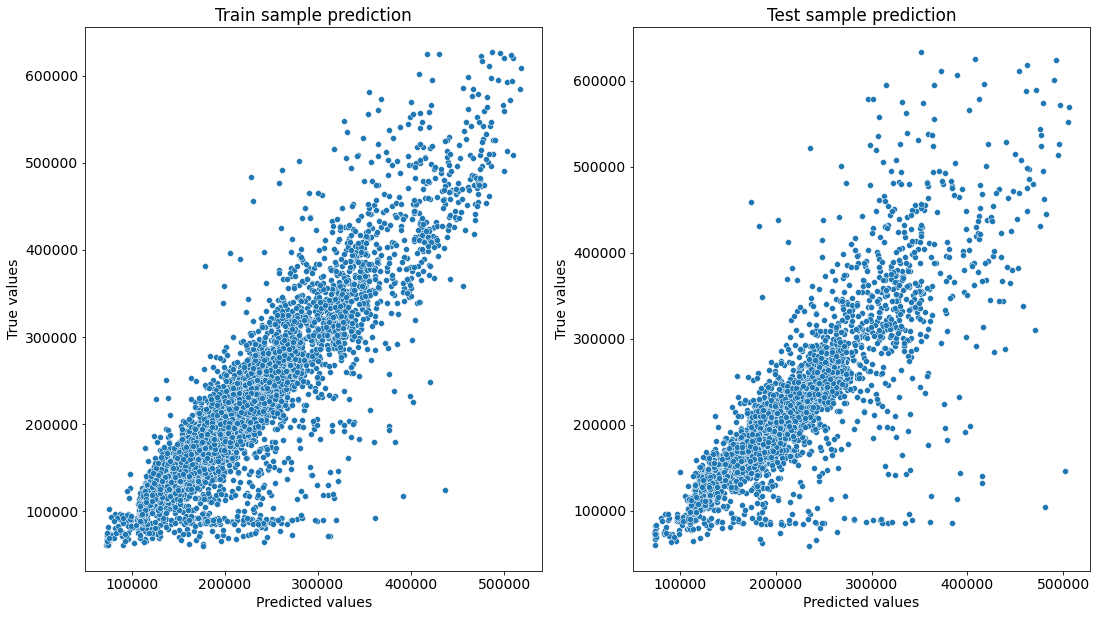

In [100]:
rfr_model = RandomForestRegressor(criterion='mse',
                                 max_depth=9, # глубина дерева  
                                 min_samples_leaf=10, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42, 
                                 max_features=8,
                                 n_estimators=250  # кол-во деревьев
                                 )

rfr_model.fit(X_train, y_train)
y_train_preds = rfr_model.predict(X_train)
y_test_preds = rfr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [101]:
clf.best_score_

0.7482762528990994

#### Кросс-валидация

In [102]:
cv_score = cross_val_score(rfr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.7613725 , 0.72832756, 0.74967324])

In [103]:
cv_score.mean()

0.7464577666032671

#### Важность признаков

In [104]:
feature_importances = pd.DataFrame(zip(X_train.columns, rfr_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
23,MedPriceByDistrict,0.361482
1,Square,0.208721
0,Rooms,0.085871
21,DistrictSize,0.060482
2,LifeSquare,0.052978
22,IsDistrictLarge,0.034567
11,Social_2,0.029215
10,Social_1,0.024052
26,MedSocialByDistrict3,0.019063
27,MedSocialByDistrict2,0.018828


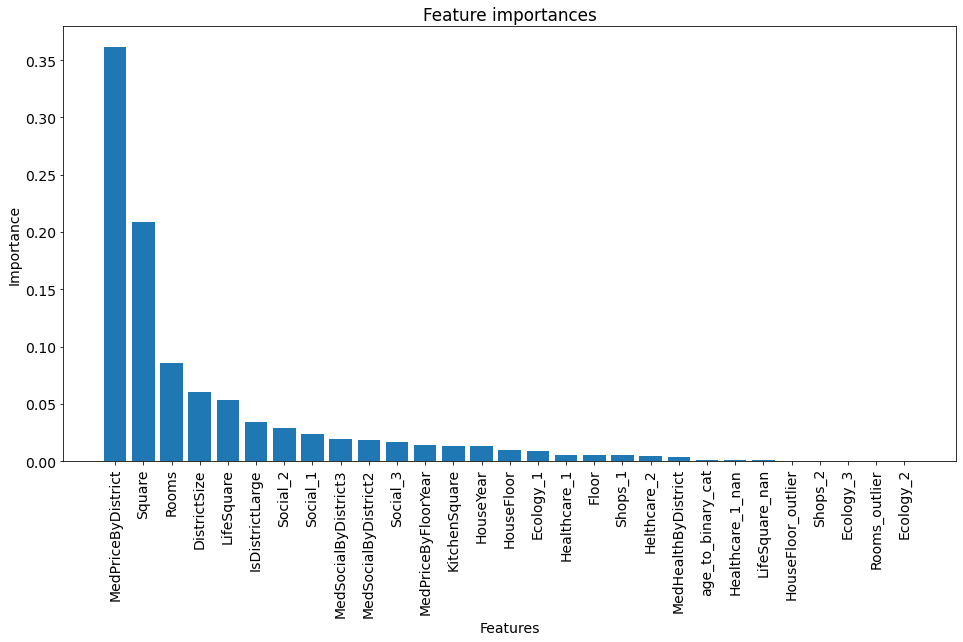

In [105]:
plt.figure(figsize = (16, 8))
plt.bar(feature_importances['feature_name'], feature_importances['importance'])
plt.xticks(rotation='90')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importances')
plt.show()

In [106]:
gbr_model = GradientBoostingRegressor(criterion='mse',
                                     random_state=65)

In [107]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10],
         'min_samples_leaf': [10, 20, 30, 50]}
clf_new = GridSearchCV(gbr_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                 )
clf_new.fit(X_train, y_train)

Wall time: 12min 17s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 random_state=65),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [10, 20, 30, 50],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [108]:
clf_new.best_params_

{'max_depth': 5, 'min_samples_leaf': 20, 'n_estimators': 200}

In [109]:
fin_gbr_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=20,
                                        random_state=42,
                                        n_estimators=200)

fin_gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=20,
                          n_estimators=200, random_state=42)

Train R2:	0.882
Test R2:	0.723


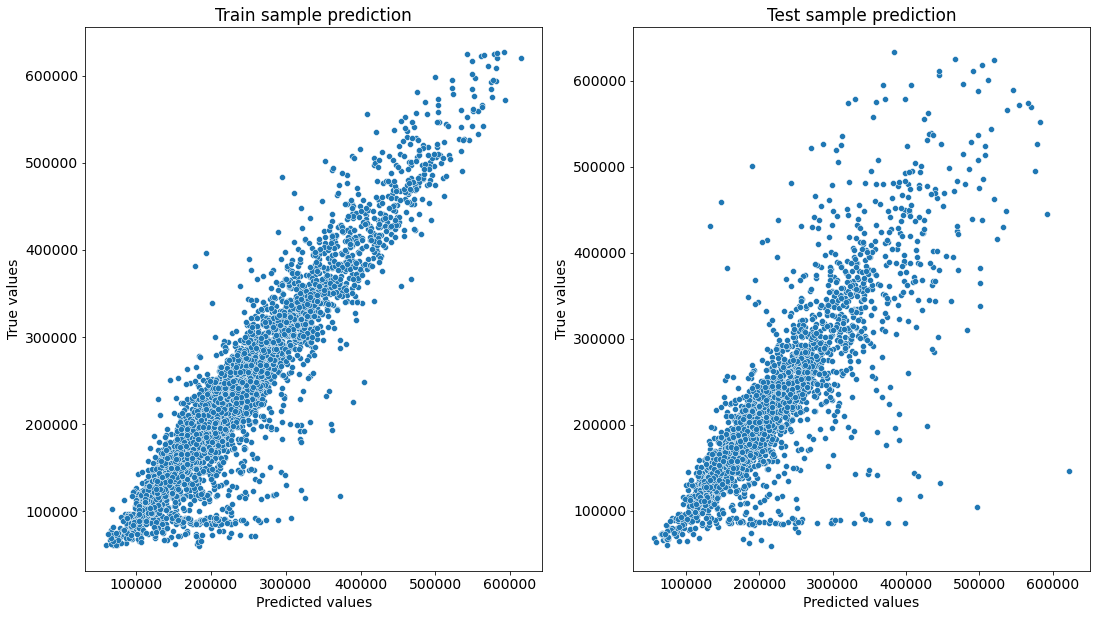

In [110]:
y_train_preds = fin_gbr_model.predict(X_train)
y_test_preds = fin_gbr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Построение модели на test датасете

In [111]:
test_df.shape

(5000, 29)

In [112]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear,MedHealthByDistrict,MedSocialByDistrict3,MedSocialByDistrict2,age_to_binary_cat
0,-1.099587,-0.875534,-0.927697,-0.438141,-0.435422,-0.546260,-0.810087,-0.700705,1,1,...,0,0,-0.480186,-0.795833,-0.525627,-0.299406,-0.208793,-0.314338,-0.171343,-0.43934
1,-1.099587,-0.620560,0.118476,1.386312,-0.048483,0.662739,1.758678,-0.399428,1,1,...,0,1,-0.000605,1.256546,-1.037525,-0.669643,-0.891855,-0.292684,-1.167467,2.27614
2,0.132186,0.132506,0.340669,1.021422,2.273154,0.964989,-0.427505,0.764732,1,1,...,1,1,2.266506,1.256546,-0.591495,-0.872197,-0.891855,-0.335992,-1.094828,-0.43934
3,1.363959,-0.305085,-0.266023,-0.073250,-1.015832,-1.604135,-1.083359,-0.885051,1,1,...,0,1,1.132950,1.256546,-0.504743,-0.579467,-0.891855,-0.335992,-1.206581,-0.43934
4,-1.099587,-0.118283,0.357362,-1.167923,0.144987,0.662739,-0.427505,1.584722,1,1,...,1,0,-0.540134,-0.795833,-0.615495,-0.225875,-0.891855,-0.206066,-0.962248,-0.43934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.132186,-0.593399,-0.424913,-0.438141,-0.822362,-1.150760,-1.247323,-0.420307,1,1,...,0,1,-0.589182,-0.795833,-0.366695,-0.579467,-0.208793,-0.162757,0.226903,-0.43934
4996,1.363959,1.695096,2.407756,1.386312,2.660093,2.173989,1.813332,-0.494777,1,1,...,0,0,-0.752676,-0.795833,2.720472,-0.159693,-0.891855,-0.249375,-0.619370,2.27614
4997,-1.099587,-1.017758,-0.931763,-0.438141,-1.015832,-1.150760,-1.028705,-0.679213,1,1,...,0,0,-0.600082,-0.795833,-0.715856,-0.579467,1.157332,-0.032831,0.338402,-0.43934
4998,-1.099587,-0.795860,-0.843552,1.021422,0.144987,0.209364,-0.810087,-0.258284,1,1,...,0,1,-0.676379,-0.795833,-0.339478,-0.225875,-0.891855,-0.119448,0.698551,-0.43934


In [114]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [115]:
predictions = fin_gbr_model.predict(test_df)
predictions

array([163869.01741772, 132721.15625172, 137593.88395393, ...,
       147235.86628514, 190759.88886573, 286513.77637692])

In [116]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163869.017418
1,5925,132721.156252
2,960,137593.883954
3,3848,125457.003263
4,746,179043.841507


In [117]:
submit.to_csv('fin_gbr_submit.csv', index=False, encoding='utf-8')

##### Дополнение

Без сортировки минамальных значений

In [118]:
# predictions_rfr = rfr_model.predict(test_df)
# predictions_rfr

In [119]:
# submit['Price'] = predictions_rfr
# submit.head()